Code Explaination:

This Python code utilizes a trained machine learning model to predict potential failures in a job-shop scheduling scenario, integrating the predictions with optimization constraints in the `pulp` library to minimize tardiness. Let’s break down the components and key constraints considered in the production scheduling:

### Key Components of the Code

1. **Machine Learning Model Loading and Prediction**:
   - The code loads a saved machine learning model (`failure_prediction_model.pkl`) using `pickle` to predict failure probabilities for each job-machine combination.
   - **Input Data Generation**: The input data includes various features (e.g., temperature, speed, torque) essential for the ML model to estimate failure probabilities.
   - **Feature Engineering**: Derived features (`Temperature_diff`, `Torque_per_rpm`, `Tool_wear_rate`) are computed from the input data to enhance prediction accuracy.
   - **Failure Prediction**: Using the model, each machine-job combination’s failure probability is assessed. If a probability exceeds 0.5, it’s flagged as a failure.
   - **Failure Constraint**: To avoid overloading the system, the number of machine failures is capped at three.

2. **Processing and Repair Time Adjustments**:
   - **Repair Time Integration**: For each failed machine-job pair, a random repair time is generated, and the processing time for that job on the machine is increased accordingly.
   - **Due Dates**: Each job is assigned a due date based on the total processing time with a buffer.

3. **Job-Shop Scheduling Optimization Using PuLP**:
   - **Objective**: Minimize the sum of tardiness across all jobs, defined as the difference between a job’s completion time and its due date if it finishes late.
   - **Decision Variables**:
     - `start_times`: The start time of each job on each machine.
     - `tardiness`: The lateness of each job beyond its due date.

### Production Constraints in the `pulp` Solver

1. **Sequential Processing Constraint**:
   - Ensures that each job is processed sequentially across machines. For example, if Job `j` finishes on Machine `m` at time `t`, it can start on Machine `m+1` only after `t + processing_time`.
   - This constraint respects the processing order for each job across all machines.

2. **Machine Capacity Constraint**:
   - Enforces that no two jobs overlap on the same machine at the same time. This means for any two jobs (`j`, `j_prime`) on the same machine `m`, one job’s start time must be after the other job’s completion time.
   - This constraint ensures machines are used sequentially and not over-allocated.

3. **Tardiness Constraint**:
   - Defines how late a job can be completed based on its due date and accounts for penalties if completed beyond the set due date.
   - `tardiness[j]` captures the lateness if Job `j` completes after its due date.

4. **Failure and Repair Constraints**:
   - The code dynamically adjusts processing times for jobs on machines flagged for failure. Machines with failures have additional repair time added to their processing time.
   - This constraint models the real-world condition where machines may be temporarily unavailable, leading to delayed job processing.

### Solution and Visualization

1. **Optimization Solution**: The `pulp` solver (`problem.solve()`) aims to find an optimal schedule that minimizes total tardiness.
2. **Gantt Chart Creation**: A Gantt chart visualizes job start and finish times across machines, including repair delays, providing a graphical representation of the job-shop schedule.
3. **Start and Finish Times Matrix**: A DataFrame (`start_finish_matrix`) is generated to display start and finish times for each job-machine combination, making it easier to track scheduling.

### Summary
The code builds a robust job scheduling model that integrates predicted machine failures, enforces sequential job-machine processing, manages machine capacities, and minimizes tardiness, making it well-suited for production scenarios with potential disruptions.

In [30]:
import pickle
import pulp
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved model
path = r'failure_prediction_model.pkl'
with open(path, "rb") as f:
    ml_model = pickle.load(f)


# Define the number of jobs and machines
num_jobs = 10
num_machines = 10

# Processing times for jobs on machines
processing_times = [
    [74, 21, 58, 83, 31, 61, 94, 66, 37, 99],  # Job 0
    [28, 27, 34, 64, 54, 76, 43, 42, 88, 49],  # Job 1
    [89, 52, 7, 32, 46, 60, 87, 36, 34, 48],   # Job 2
    [60, 26, 76, 29, 79, 19, 95, 77, 24, 85],  # Job 3
    [54, 12, 70, 99, 16, 41, 68, 30, 5, 58],   # Job 4
    [92, 54, 57, 65, 51, 53, 19, 40, 79, 24],  # Job 5
    [90, 88, 27, 50, 49, 82, 96, 60, 37, 84],  # Job 6
    [40, 25, 95, 84, 60, 90, 57, 38, 28, 40],  # Job 7
    [25, 91, 56, 62, 76, 99, 58, 74, 18, 96],  # Job 8
    [15, 8, 95, 90, 76, 42, 70, 67, 98, 71]    # Job 9
]

# Generate input data for the machine-job combinations
input_data = pd.DataFrame({
    'Type': random.choices(['L', 'M', 'H'], k=num_jobs * num_machines),
    'Air temperature [K]': np.random.uniform(290, 310, num_jobs * num_machines),
    'Process temperature [K]': np.random.uniform(300, 320, num_jobs * num_machines),
    'Rotational speed [rpm]': np.random.uniform(1000, 2000, num_jobs * num_machines),
    'Torque [Nm]': np.random.uniform(20, 100, num_jobs * num_machines),
    'Tool wear [min]': np.random.uniform(0, 300, num_jobs * num_machines)
})

# Feature engineering
input_data['Temperature_diff'] = input_data['Process temperature [K]'] - input_data['Air temperature [K]']
input_data['Torque_per_rpm'] = input_data['Torque [Nm]'] / (input_data['Rotational speed [rpm]'] + 1e-6)
input_data['Tool_wear_rate'] = input_data['Tool wear [min]'] / (input_data['Process temperature [K]'] + 1e-6)

# Predict failure probabilities and define failure flags
failure_probabilities = ml_model.predict_proba(input_data)[:, 1]
failure_flags = np.where(failure_probabilities > 0.5, 1, 0)

# Limit failures to a maximum of 3 machines
failure_count = np.sum(failure_flags)
if failure_count > 3:
    indices = np.where(failure_flags == 1)[0]
    np.random.shuffle(indices)
    failure_flags[indices[3:]] = 0

# Reshape failure flags into a matrix
failure_matrix = failure_flags.reshape(num_jobs, num_machines)

# Define repair times and adjust processing times for machines with failures
repair_times = {}
min_repair_time, max_repair_time = 10, 500
for j in range(num_jobs):
    for m in range(num_machines):
        if failure_matrix[j, m] == 1:
            repair_time = random.randint(min_repair_time, max_repair_time)
            repair_times[(j, m)] = repair_time
            processing_times[j][m] += repair_time
            print(f"Machine {m} failure during Job {j} - Repair time: {repair_time} - Adjusted processing time: {processing_times[j][m]}")

# Define reasonable due dates based on a buffer added to the sum of processing times per job
due_dates = {j: sum(processing_times[j]) + 100 for j in range(num_jobs)}  # Adding a buffer of 100 time units

# Scheduling problem setup
problem = pulp.LpProblem("JobShopSchedulingWithMLFailures", pulp.LpMinimize)

# Define variables
start_times = pulp.LpVariable.dicts("start", ((j, m) for j in range(num_jobs) for m in range(num_machines)), lowBound=0)
tardiness = pulp.LpVariable.dicts("tardiness", range(num_jobs), lowBound=0)

# Objective: minimize total tardiness
problem += pulp.lpSum(tardiness[j] for j in range(num_jobs)), "TotalTardiness"

# Sequential processing constraints
for j in range(num_jobs):
    for m in range(num_machines - 1):
        problem += start_times[(j, m + 1)] >= start_times[(j, m)] + processing_times[j][m]

# Machine capacity constraints to ensure no overlap on the same machine
for m in range(num_machines):
    for j in range(num_jobs):
        for j_prime in range(j + 1, num_jobs):
            problem += (start_times[(j_prime, m)] >= start_times[(j, m)] + processing_times[j][m]) \
                       or (start_times[(j, m)] >= start_times[(j_prime, m)] + processing_times[j_prime][m])

# Tardiness constraints based on due dates
for j in range(num_jobs):
    last_machine = num_machines - 1
    problem += (start_times[(j, last_machine)] + processing_times[j][last_machine] <= due_dates[j] + tardiness[j]), \
               f"TardinessConstraint_Job{j}"

# Solve the problem
status = problem.solve()
print(f"Status: {pulp.LpStatus[status]}")

# Print the total tardiness in the system if the solution is optimal
if status == pulp.LpStatusOptimal:
    total_tardiness = pulp.value(problem.objective)
    print(f"Total Tardiness in the System: {total_tardiness}")

    for j in range(num_jobs):
        for m in range(num_machines):
            start = pulp.value(start_times[(j, m)])
           # if start is not None:
                #print(f"Job {j} on Machine {m} starts at {start} and finishes at {start + processing_times[j][m]}")
        print(f"Tardiness for Job {j}: {pulp.value(tardiness[j])}")

# Generate Gantt chart data
tasks = []
for j in range(num_jobs):
    for m in range(num_machines):
        start_time = pulp.value(start_times[(j, m)])
        if start_time is not None:
            tasks.append({
                "Job": f"Job{j}", "Machine": f"Machine{m}",
                "Start": start_time, "Finish": start_time + processing_times[j][m]
            })




# Start and Finish Times Matrix including repair times
start_finish_matrix = pd.DataFrame(index=[f"Machine {m}" for m in range(num_machines)],
                                   columns=[f"Job {j}" for j in range(num_jobs)])
for m in range(num_machines):
    for j in range(num_jobs):
        start_time = pulp.value(start_times[(j, m)])
        finish_time = start_time + processing_times[j][m]
        start_finish_matrix.loc[f"Machine {m}", f"Job {j}"] = f"{start_time:.2f} - {finish_time:.2f}"

print("Start and Finish Times Matrix (including repair time):")
display(start_finish_matrix)


Machine 7 failure during Job 0 - Repair time: 148 - Adjusted processing time: 214
Machine 8 failure during Job 0 - Repair time: 281 - Adjusted processing time: 318
Machine 5 failure during Job 3 - Repair time: 22 - Adjusted processing time: 41
Status: Optimal
Total Tardiness in the System: 6102.0
Tardiness for Job 0: 0.0
Tardiness for Job 1: 497.0
Tardiness for Job 2: 559.0
Tardiness for Job 3: 543.0
Tardiness for Job 4: 740.0
Tardiness for Job 5: 683.0
Tardiness for Job 6: 638.0
Tardiness for Job 7: 784.0
Tardiness for Job 8: 782.0
Tardiness for Job 9: 876.0
Start and Finish Times Matrix (including repair time):


,Job 0,Job 1,Job 2,Job 3,Job 4,Job 5,Job 6,Job 7,Job 8,Job 9
Machine 0,0.00 - 74.00,74.00 - 102.00,102.00 - 191.00,191.00 - 251.00,251.00 - 305.00,305.00 - 397.00,397.00 - 487.00,487.00 - 527.00,527.00 - 552.00,676.00 - 691.00
Machine 1,74.00 - 95.00,102.00 - 129.00,191.00 - 243.00,251.00 - 277.00,305.00 - 317.00,397.00 - 451.00,487.00 - 575.00,575.00 - 600.00,600.00 - 691.00,691.00 - 699.00
Machine 2,95.00 - 153.00,153.00 - 187.00,243.00 - 250.00,277.00 - 353.00,353.00 - 423.00,451.00 - 508.00,575.00 - 602.00,602.00 - 697.00,697.00 - 753.00,753.00 - 848.00
Machine 3,153.00 - 236.00,236.00 - 300.00,300.00 - 332.00,353.00 - 382.00,423.00 - 522.00,522.00 - 587.00,602.00 - 652.00,697.00 - 781.00,781.00 - 843.00,848.00 - 938.00
Machine 4,236.00 - 267.00,300.00 - 354.00,354.00 - 400.00,400.00 - 479.00,522.00 - 538.00,587.00 - 638.00,652.00 - 701.00,781.00 - 841.00,843.00 - 919.00,954.00 - 1030.00
Machine 5,267.00 - 328.00,354.00 - 430.00,430.00 - 490.00,490.00 - 531.00,538.00 - 579.00,638.00 - 691.00,701.00 - 783.00,841.00 - 931.00,931.00 - 1030.00,1030.00 - 1072.00
Machine 6,328.00 - 422.00,430.00 - 473.00,490.00 - 577.00,577.00 - 672.00,672.00 - 740.00,740.00 - 759.00,783.00 - 879.00,931.00 - 988.00,1030.00 - 1088.00,1092.00 - 1162.00
Machine 7,422.00 - 636.00,636.00 - 678.00,678.00 - 714.00,714.00 - 791.00,791.00 - 821.00,821.00 - 861.00,879.00 - 939.00,988.00 - 1026.00,1088.00 - 1162.00,1162.00 - 1229.00
Machine 8,636.00 - 954.00,954.00 - 1042.00,1042.00 - 1076.00,1076.00 - 1100.00,1100.00 - 1105.00,1105.00 - 1184.00,1184.00 - 1221.00,1221.00 - 1249.00,1249.00 - 1267.00,1439.00 - 1537.00
Machine 9,954.00 - 1053.00,1053.00 - 1102.00,1102.00 - 1150.00,1150.00 - 1235.00,1235.00 - 1293.00,1293.00 - 1317.00,1317.00 - 1401.00,1401.00 - 1441.00,1441.00 - 1537.00,1537.00 - 1608.00


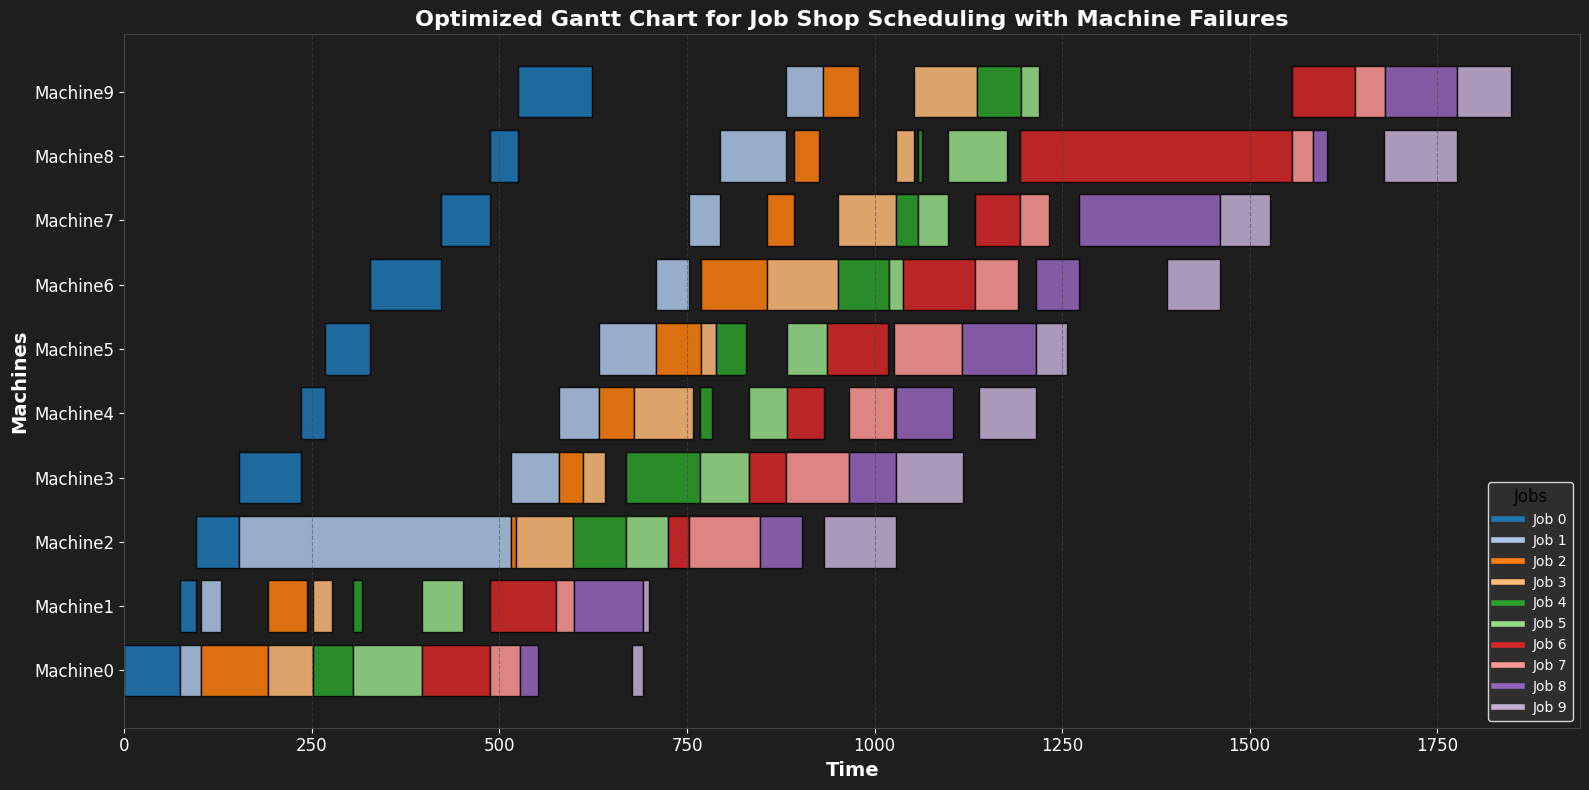

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `tasks` DataFrame is already populated with 'Job', 'Machine', 'Start', and 'Finish' columns

# Define unique colors for each job for better contrast
colors = plt.cm.tab20.colors  # Use a colormap for a variety of distinct colors
job_colors = {f"Job{j}": colors[j % len(colors)] for j in range(num_jobs)}

# Create optimized Gantt chart with dark theme
fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor('#1e1e1e')  
ax.set_facecolor('#1e1e1e')  

# Plot each job on the Gantt chart 
for i, row in df.iterrows():
    job_color = job_colors[row['Job']]
    ax.barh(
        row['Machine'], row['Finish'] - row['Start'], left=row['Start'],
        color=job_color, edgecolor='black', alpha=0.85
    )

# Create a legend with unique job colors and white text
job_handles = [plt.Line2D([0], [0], color=job_colors[f"Job{j}"], lw=4) for j in range(num_jobs)]
ax.legend(job_handles, [f"Job {j}" for j in range(num_jobs)], title="Jobs", loc='lower right', 
          fontsize=10, title_fontsize='12', facecolor='#333333', edgecolor='white', labelcolor='white')

# Customize axis labels, title, and grid
ax.set_xlabel('Time', fontsize=14, color='white', fontweight='bold')
ax.set_ylabel('Machines', fontsize=14, color='white', fontweight='bold')
ax.set_title('Optimized Gantt Chart for Job Shop Scheduling with Machine Failures', fontsize=16, color='white', fontweight='bold')

# Enhance ticks and grid for better visual clarity
ax.tick_params(colors='white', labelsize=12)
ax.grid(axis='x', linestyle='--', color='#444444', alpha=0.5)

# Customize spines
for spine in ax.spines.values():
    spine.set_edgecolor('#444444')

plt.tight_layout()
plt.show()


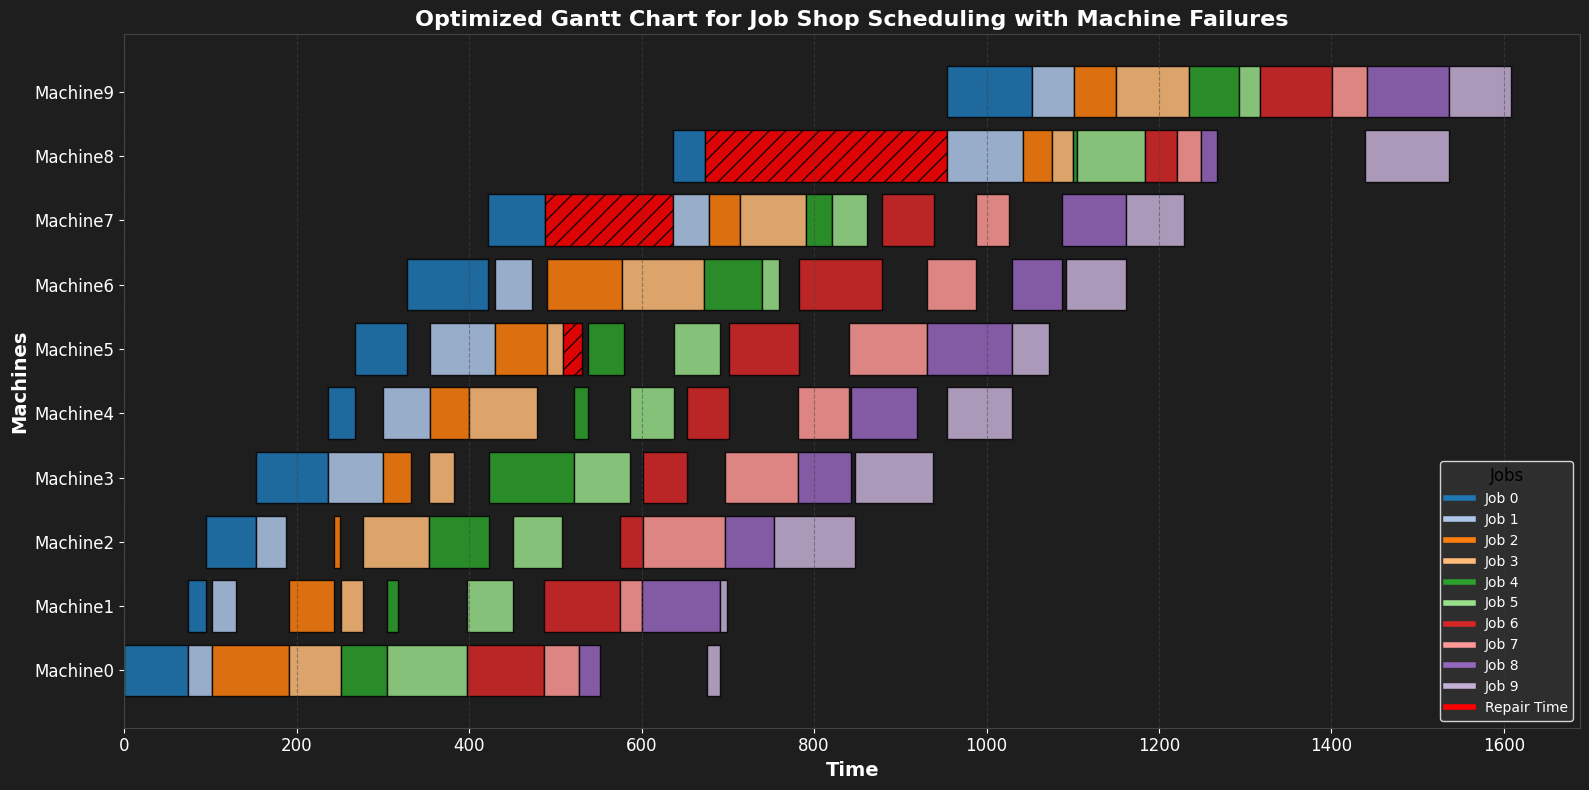

In [34]:
# Generate Gantt chart data including repair times
tasks = []
for j in range(num_jobs):
    for m in range(num_machines):
        start_time = pulp.value(start_times[(j, m)])
        repair_time = repair_times.get((j, m), 0)  # Get repair time if it exists, otherwise 0
        if start_time is not None:
            tasks.append({
                "Job": f"Job{j}", 
                "Machine": f"Machine{m}",
                "Start": start_time, 
                "Finish": start_time + processing_times[j][m],
                "Repair": repair_time
            })

# Convert to DataFrame
tasks_df = pd.DataFrame(tasks)
import matplotlib.pyplot as plt

# Define unique colors for each job for better contrast
colors = plt.cm.tab20.colors  # Use a colormap for a variety of distinct colors
job_colors = {f"Job{j}": colors[j % len(colors)] for j in range(num_jobs)}

# Create optimized Gantt chart with dark theme
fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor('#1e1e1e')  
ax.set_facecolor('#1e1e1e')  

# Plot each job on the Gantt chart 
for i, row in tasks_df.iterrows():
    job_color = job_colors[row['Job']]
    
    # Plot the main processing time
    ax.barh(
        row['Machine'], row['Finish'] - row['Start'] - row['Repair'], left=row['Start'],
        color=job_color, edgecolor='black', alpha=0.85
    )
    
    # Plot the repair time if applicable
    if row['Repair'] > 0:
        ax.barh(
            row['Machine'], row['Repair'], left=row['Finish'] - row['Repair'],
            color='red', edgecolor='black', alpha=0.85, hatch='//'
        )

# Create a legend with unique job colors and white text
job_handles = [plt.Line2D([0], [0], color=job_colors[f"Job{j}"], lw=4) for j in range(num_jobs)]
job_handles.append(plt.Line2D([0], [0], color='red', lw=4, linestyle='-', label='Repair Time'))
ax.legend(job_handles, [f"Job {j}" for j in range(num_jobs)] + ['Repair Time'], title="Jobs", loc='lower right', 
          fontsize=10, title_fontsize='12', facecolor='#333333', edgecolor='white', labelcolor='white')

# Customize axis labels, title, and grid
ax.set_xlabel('Time', fontsize=14, color='white', fontweight='bold')
ax.set_ylabel('Machines', fontsize=14, color='white', fontweight='bold')
ax.set_title('Optimized Gantt Chart for Job Shop Scheduling with Machine Failures', fontsize=16, color='white', fontweight='bold')

# Enhance ticks and grid for better visual clarity
ax.tick_params(colors='white', labelsize=12)
ax.grid(axis='x', linestyle='--', color='#444444', alpha=0.5)

# Customize spines
for spine in ax.spines.values():
    spine.set_edgecolor('#444444')

plt.tight_layout()
plt.show()


Compare the production scheduling with and without machine failure

In [24]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming num_jobs, num_machines, processing_times, and due_dates are defined as before

# Define due dates without considering failures in the calculation
due_dates_no_failure_adjustment = {j: sum(processing_times[j]) for j in range(num_jobs)}

# Scenario 1: Scheduling without failure-adjusted due dates
problem_no_failure_adjustment = pulp.LpProblem("JobShopSchedulingWithoutFailureAdjustedDueDates", pulp.LpMinimize)

# Define variables for start times and tardiness in Scenario 1
start_times_no_failure_adjustment = pulp.LpVariable.dicts(
    "start_no_failure_adjustment", ((j, m) for j in range(num_jobs) for m in range(num_machines)), lowBound=0
)
tardiness_no_failure_adjustment = pulp.LpVariable.dicts("tardiness_no_failure_adjustment", range(num_jobs), lowBound=0)

# Objective for Scenario 1
problem_no_failure_adjustment += pulp.lpSum(tardiness_no_failure_adjustment[j] for j in range(num_jobs)), "TotalTardinessNoFailureAdjustedDueDates"

# Sequential processing constraints for Scenario 1
for j in range(num_jobs):
    for m in range(num_machines - 1):
        problem_no_failure_adjustment += (
            start_times_no_failure_adjustment[(j, m + 1)] >= start_times_no_failure_adjustment[(j, m)] + processing_times[j][m]
        )

# Machine capacity constraints for Scenario 1
for m in range(num_machines):
    for j in range(num_jobs):
        for j_prime in range(j + 1, num_jobs):
            problem_no_failure_adjustment += (
                start_times_no_failure_adjustment[(j_prime, m)] >= start_times_no_failure_adjustment[(j, m)] + processing_times[j][m]
            ) or (
                start_times_no_failure_adjustment[(j, m)] >= start_times_no_failure_adjustment[(j_prime, m)] + processing_times[j_prime][m]
            )

# Tardiness constraints using due_dates_no_failure_adjustment for Scenario 1
for j in range(num_jobs):
    last_machine = num_machines - 1
    problem_no_failure_adjustment += (
        start_times_no_failure_adjustment[(j, last_machine)] + processing_times[j][last_machine] <= due_dates_no_failure_adjustment[j] + tardiness_no_failure_adjustment[j]
    ), f"TardinessConstraint_NoFailureAdjustment_Job{j}"

# Solve Scenario 1
status_no_failure_adjustment = problem_no_failure_adjustment.solve()

# Scenario 2: Solve the original problem with failure-adjusted due dates (already set up as `problem`)
status_with_failure_adjustment = problem.solve()

# Calculate tardiness values for each job in both scenarios based on start and due dates
tardiness_values_scenario_1 = [
    pulp.value(tardiness_no_failure_adjustment[j]) if status_no_failure_adjustment == pulp.LpStatusOptimal else None for j in range(num_jobs)
]
tardiness_values_scenario_2 = [
    pulp.value(tardiness[j]) if status_with_failure_adjustment == pulp.LpStatusOptimal else None for j in range(num_jobs)
]

# Plot the comparison for each job
job_ids = [f"Job {j}" for j in range(num_jobs)]



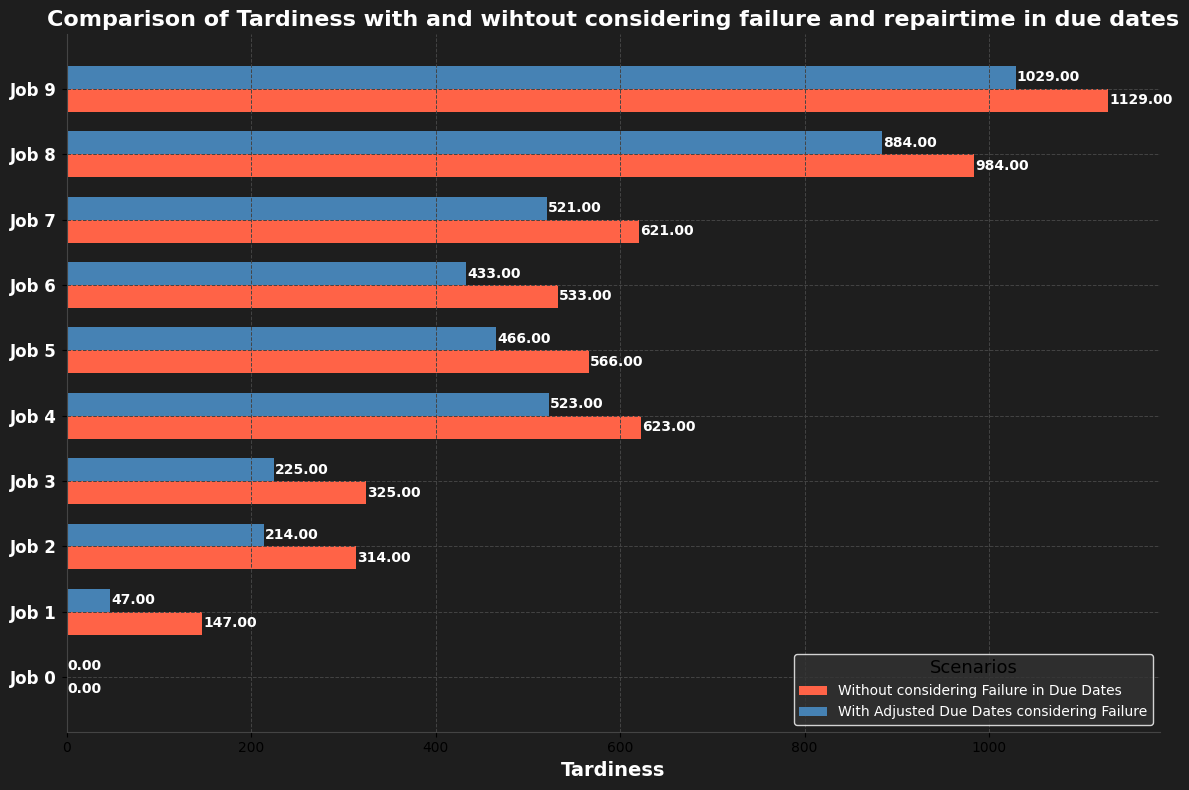

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `tardiness_values_scenario_1`, `tardiness_values_scenario_2`, and `job_ids` are already defined

fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color
fig.patch.set_facecolor('#1e1e1e')  # Dark gray for the figure background
ax.set_facecolor('#1e1e1e')  # Dark gray for the axis background

# Define y positions for jobs
y = np.arange(len(job_ids))
width = 0.35  # Width of the bars

# Plot each scenario's bars
bar1 = ax.barh(y - width / 2, tardiness_values_scenario_1, width, label="Without considering Failure in Due Dates", color='#FF6347')  # Tomato color
bar2 = ax.barh(y + width / 2, tardiness_values_scenario_2, width, label="With Adjusted Due Dates considering Failure", color='#4682B4')  # Steel blue color

# Add labels to each bar with styling
for bar in bar1 + bar2:
    ax.text(
        bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,  # Offset the text for better readability
        f'{bar.get_width():.2f}', ha='left', va='center', color='white', fontsize=10, fontweight='bold'
    )

# Customizing the axis labels, title, and legend
ax.set_yticks(y)
ax.set_yticklabels(job_ids, color='white', fontsize=12, fontweight='bold')
ax.set_xlabel("Tardiness", color='white', fontsize=14, fontweight='bold')
ax.set_title("Comparison of Tardiness with and wihtout considering failure and repairtime in due dates", color='white', fontsize=16, fontweight='bold')

# Legend without title fontweight
ax.legend(facecolor='#333333', edgecolor='white', fontsize=10, title="Scenarios", title_fontsize='13', labelcolor='white')

# Customize grid and frame
ax.grid(True, color='#444444', linestyle='--', linewidth=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#444444')
ax.spines['bottom'].set_color('#444444')

plt.tight_layout()
plt.show()
